In [1]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def rho_red_light(nx, rho_max, rho_in):
    """Computes "red light" initial condition with shock

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 

    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """
    rho = rho_max*numpy.ones(nx)
    rho[:int((nx-1)*3./4.)] = rho_in
    return rho

In [3]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx, rho_max, rho_in)

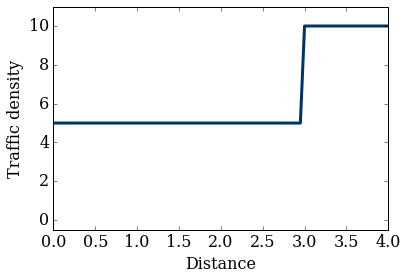

In [4]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

In [5]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho

    Parameters
    ----------
    u_max  : float
        Maximum allowed velocity
    rho    : array of floats
        Array with density of cars at every point x
    rho_max: float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

In [6]:
from matplotlib import animation
from IPython.display import HTML

In [7]:
def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

In [8]:
def laxfriedrichs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Friedrichs scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    '''
    Now, for each timestep, we're going to calculate rho^n+1, 
    then set the value of rho equal to rho^n+1 so we can calculate 
    the next iteration.  For every timestep, the entire vector
    rho^n is saved in a single row of our results array rho_n.
    '''
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:-1] = .5*(rho[2:]+rho[:-2]) - dt/(2*dx)*(F[2:]-F[:-2])
        rho_n[t,0] = rho[0] # boundary condition at x=0
        rho_n[t,-1] = rho[-1] # boundary condition at x=4
        rho = rho_n[t].copy()
        
    return rho_n

In [9]:
sigma = 1.0
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

In [10]:
rho_n.shape

(30, 81)

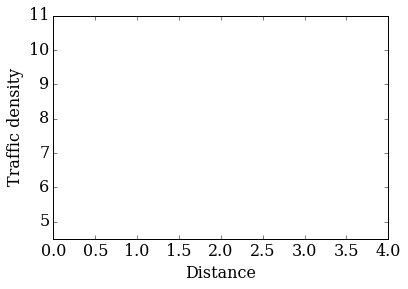

In [11]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

In [12]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

In [13]:
sigma = 0.5
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

In [14]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

In [15]:
def Jacobian(u_max, rho_max, rho):
    return u_max*(1-2*rho/rho_max)

def laxwendroff(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Wendroff scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    

    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        J = Jacobian(u_max, rho_max, rho)
        
        rho_n[t,1:-1] = rho[1:-1] - dt/(2*dx)*(F[2:]-F[:-2]) \
                           + dt**2/(4*dx**2) * ( (J[2:]+J[1:-1])*(F[2:]-F[1:-1]) \
                           - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2]) )
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [18]:
rho = rho_red_light(nx, rho_max, rho_in) 
sigma = 1
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

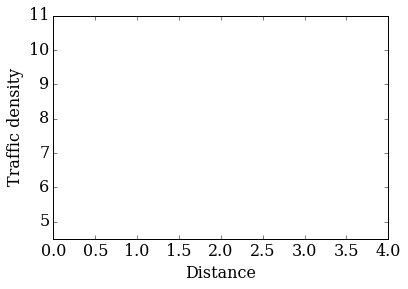

In [19]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11.),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

In [20]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

In [21]:
rho = rho_red_light(nx, rho_max, rho_in) 
sigma = 0.5
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

In [22]:
def maccormack(rho, nt, dt, dx, u_max, rho_max):
    """ Computes the solution with MacCormack scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    rho_n = numpy.zeros((nt,len(rho)))
    rho_star = numpy.empty_like(rho)
    rho_n[:,:] = rho.copy()
    rho_star = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_star[:-1] = rho[:-1] - dt/dx * (F[1:]-F[:-1])
        Fstar = computeF(u_max, rho_max, rho_star)
        rho_n[t,1:] = .5 * (rho[1:]+rho_star[1:] - dt/dx * (Fstar[1:] - Fstar[:-1]))
        rho = rho_n[t].copy()
        
    return rho_n

In [23]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 1.0
dt = sigma*dx/u_max

rho_n = maccormack(rho,nt,dt,dx,u_max,rho_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

In [24]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 0.5
dt = sigma*dx/u_max

rho_n = maccormack(rho,nt,dt,dx,u_max,rho_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())